# Configuración del proyecto
Comenzamos importando las librerías.

In [87]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud,STOPWORDS




# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers


### Dataset original

In [58]:
df = pd.read_csv('./data/train_data.csv')
df = df.reindex(np.random.permutation(df.index))  
df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
3901,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2018-02-10T00:00:00.000Z,The Echo Show is great but it is not just plug...,Not just all plug and play,Positive
2922,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-03-21T00:00:00.000Z,Bought as a Christmas gift. Works good with no...,Nice,Positive
1671,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",Amazon,"Computers,Fire Tablets,Electronics Features,Co...",Electronics,2017-01-18T00:00:00.000Z,I bought this for learning and entertaining pu...,Fun learning & entertaining,Positive
3936,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I gave the Echo 5 stars but I like Amazon prod...,Not Compatible,Positive
984,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,Amazon,"Amazon Echo,Home Theater & Audio,MP3 MP4 Playe...",Electronics,2017-01-06T00:00:00.000Z,"Love this product. It is nice looking, easy to...",Amazing,Positive


In [59]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

Leemos el csv con los datos de las reseñas y realizamos una mezcla aleatoria. Es una buena práctica mezclar los datos antes de dividirlos entre train, validation y test data. De esta manera, las clases de sentimiento se distribuyen equitativamente entre el train, validation y test y los conjuntos de prueba.

Solo mantendremos la columna *reseñas* como entrada y la columna *sentiment* como destino.

In [60]:
df = df.rename(columns={'reviews.text': 'reviews',})
df = df[['reviews', 'sentiment']]

df.head()

,reviews,sentiment
3901,The Echo Show is great but it is not just plug...,Positive
2922,Bought as a Christmas gift. Works good with no...,Positive
1671,I bought this for learning and entertaining pu...,Positive
3936,I gave the Echo 5 stars but I like Amazon prod...,Positive
984,"Love this product. It is nice looking, easy to...",Positive


In [61]:
df.count()


reviews      4000
sentiment    4000
dtype: int64

In [62]:
df.columns

Index(['reviews', 'sentiment'], dtype='object')

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 3901 to 1599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reviews    4000 non-null   object
 1   sentiment  4000 non-null   object
dtypes: object(2)
memory usage: 93.8+ KB


In [64]:
df.duplicated().sum()

402

In [65]:
df.isnull().sum()

reviews      0
sentiment    0
dtype: int64

In [66]:
df.dtypes

reviews      object
sentiment    object
dtype: object

In [67]:
df.describe()

,reviews,sentiment
count,4000,4000
unique,3598,3
top,I bought this kindle for my 11yr old granddaug...,Positive
freq,4,3749


In [68]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JOHANPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## EDA básico del conjunto de datos de entranmiento 

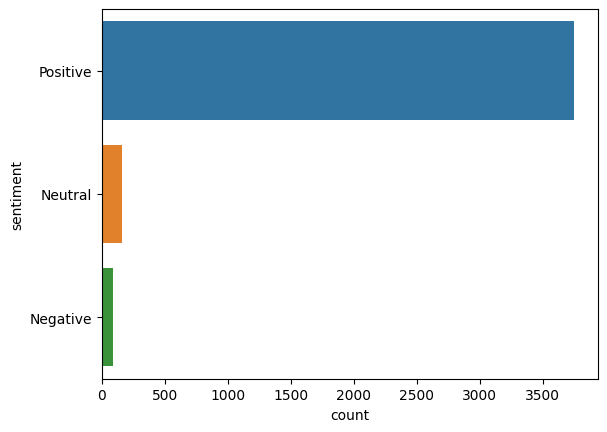

In [71]:
sns.countplot(y=df.sentiment);

<AxesSubplot:xlabel='sentiment', ylabel='count'>

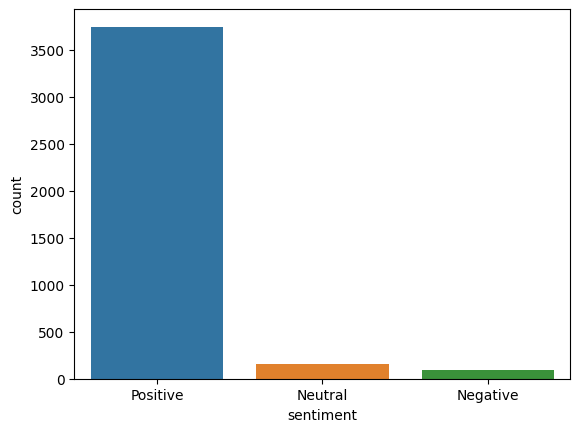

In [72]:
sns.countplot(x='sentiment', data=df)


In [73]:
df.sentiment.value_counts()

Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64

<AxesSubplot:ylabel='sentiment'>

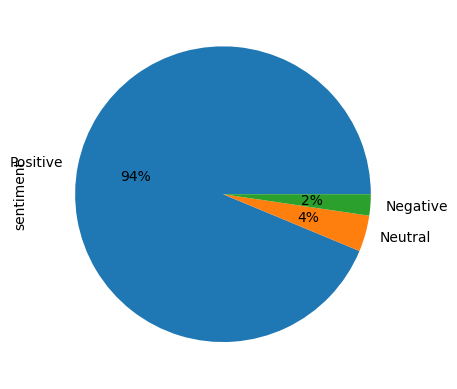

In [75]:
df['sentiment'].value_counts().plot(kind='pie', autopct= '%1.0f%%')

Positive words


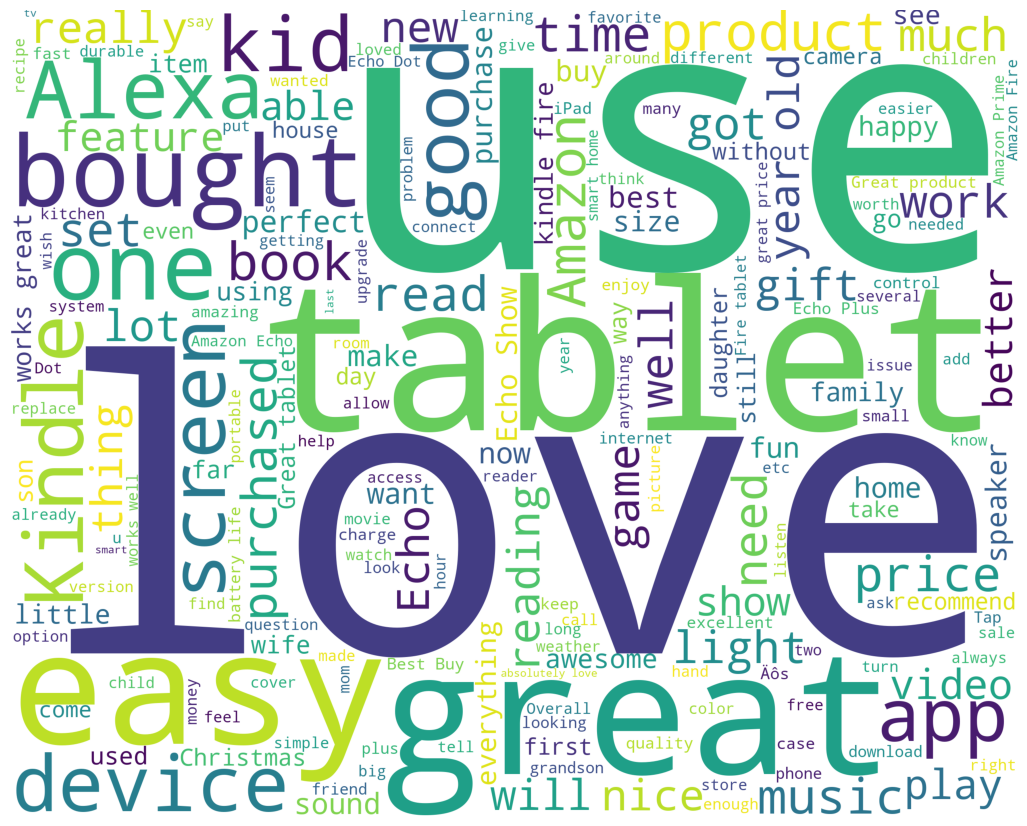

Negative words


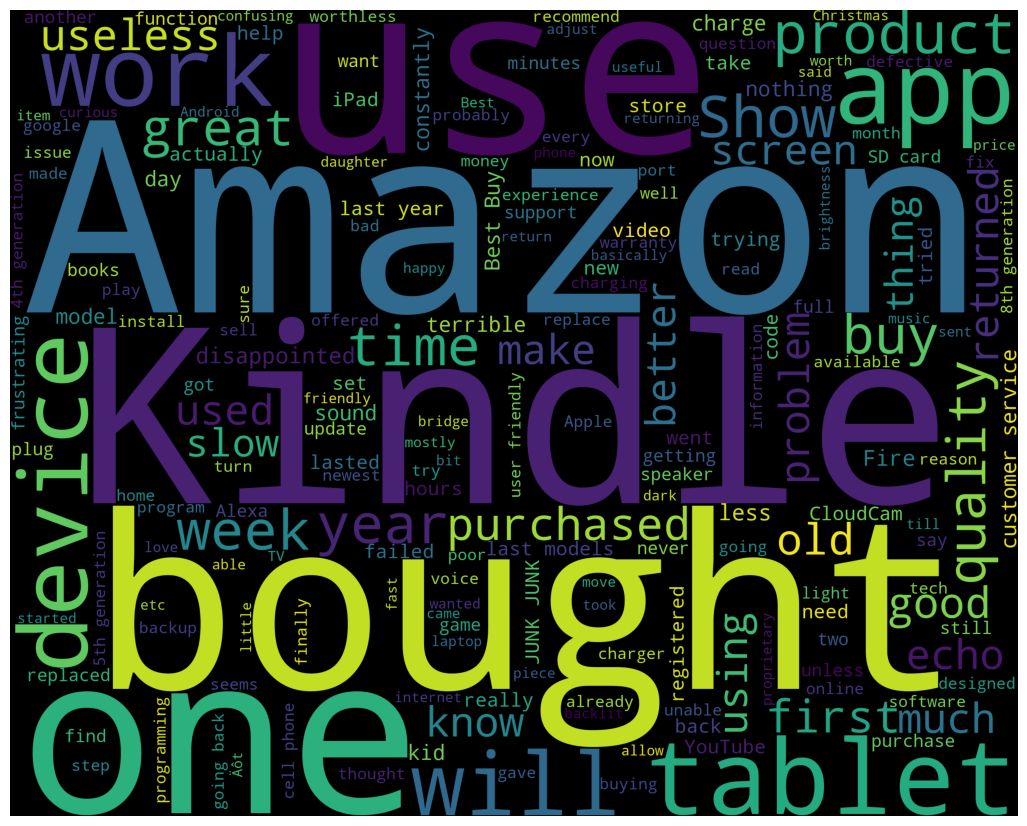

In [80]:
train_pos = df[ df['sentiment'] == 'Positive']
train_pos = train_pos['reviews']
train_neg = df[ df['sentiment'] == 'Negative']
train_neg = train_neg['reviews']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

# Data preparation

### Data cleaning
The first thing we'll do is removing stopwords. These words do not have any value for predicting the sentiment. Furthermore, as we want to build a model that can be used for other airline companies as well, we remove the mentions.

In [ ]:


def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
df.reviews = df.reviews.apply(remove_stopwords).apply(remove_mentions)
df.head()

,reviews,sentiment
2862,Amazon Fire HD8 Tablet 16GB Wi-Fi Black purcha...,Positive
474,loving Amazon Echo Show. It makes life easier!...,Positive
2148,It fits easily smallest purse always hand wait...,Positive
1408,looking cost effective solution satisfy childr...,Positive
2437,"would get another, works great, fun options",Positive


### Train-Test split
The evaluation of the model performance needs to be done on a separate test set. As such, we can estimate how well the model generalizes. This is done with the *train_test_split* method of scikit-learn.

In [81]:
X_train, X_test, y_train, y_test = train_test_split(df.reviews, df.sentiment, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 3600
# Test data samples: 400


### Converting words to numbers
To use the text as input for a model, we first need to convert the tweet's words into tokens, which simply means converting the words to integers that refer to an index in a dictionary. Here we will only keep the most frequent words in the train set.

We clean up the text by applying *filters* and putting the words to *lowercase*. Words are separated by spaces.

In [82]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 3600 documents
10000 words in dictionary
Top 5 most common words are: [('the', 4805), ('and', 3602), ('to', 3572), ('it', 3391), ('i', 3240)]


After having created the dictionary we can convert the text to a list of integer indexes. This is done with the *text_to_sequences* method of the Tokenizer.

In [ ]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

"Purchased Black FridayPros Great Price (even sale)Very powerful fast quad core processors Amazing soundWell builtCons -Amazon ads, Amazon need subsidize tablet remove adds pay $15.Inability access apps except ones Amazon. There way able accomplish add Google Play storeNet great tablet money" is converted into [260, 191, 6, 714, 619, 2172, 2173, 1526, 19, 777, 1527]


These integers should now be converted into a one-hot encoded features.

In [ ]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[260, 191, 6, 714, 619, 2172, 2173, 1526, 19, 777, 1527]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 11.0 features with a value of 1.


### Converting the target classes to numbers
We need to convert the target classes to numbers as well, which in turn are one-hot-encoded with the *to_categorical* method in keras

In [ ]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"Positive" is converted into 2
"2" is converted into [0. 0. 1.]


### Splitting of a validation set
Now that our data is ready, we split of a validation set. This validation set will be used to evaluate the model performance when we tune the parameters of the model. 

In [ ]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (360, 10000)


# Deep learning

### Baseline model
We start with a model with 2 densely connected layers of 64 hidden elements. The *input_shape* for the first layer is equal to the number of words we allowed in the dictionary and for which we created one-hot-encoded features.

As we need to predict 3 different sentiment classes, the last layer has 3 hidden elements. The *softmax* activation function makes sure the three probabilities sum up to 1.

In the first layer we need to estimate 640064 weights. This is determined by (nb inputs * nb hidden elements) + nb bias terms, or (10000 x 64) + 64 = 640064<br>
In the second layer we estimate (64 x 64) + 64 = 4160 weights<br>
In the last layer we estimate (64 x 3) + 3 = 195 weights<br>

In [ ]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


Because this project is a multi-class, single-label prediction, we use *categorical_crossentropy* as the loss function and *softmax* as the final activation function. We fit the model on the remaining train data and validate on the validation set. We run for a predetermined number of epochs and will see when the model starts to overfit.

In [ ]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [ ]:
base_history = deep_model(base_model)

To evaluate the model performance, we will look at the training and validation loss and accuracy.

In [ ]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

We can see here that the validation loss starts to increase as from epoch 4. The training loss continues to lower, which is normal as the model is trained to fit the train data as good as possible.

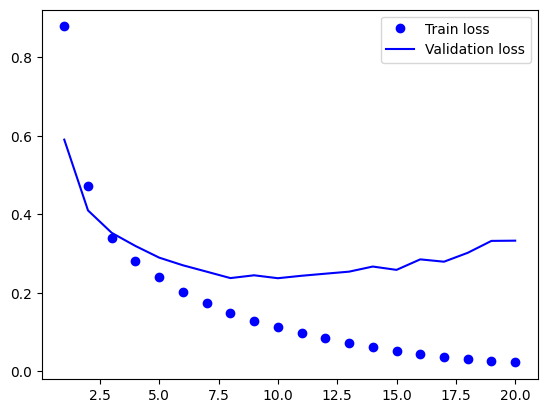

In [ ]:
eval_metric(base_history, 'loss')

Just as with the validation loss, the validation accuracy peaks at an early epoch. After that, it goes down slightly. So to conclude, we can say that the model starts overfitting as from epoch 4. 

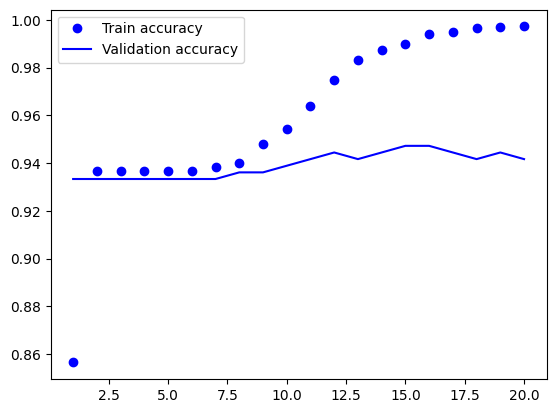

In [ ]:
eval_metric(base_history, 'accuracy')


### Handling overfitting
Now, we can try to do something about the overfitting. There are different options to do that.
* Option 1: reduce the network's size by removing layers or reducing the number of hidden elements in the layers
* Option 2: add regularization, which comes down to adding a cost to the loss function for large weights
* Option 3: adding dropout layers, which will randomly remove certain features by setting them to zero

#### Reducing the network's size
We reduce the network's size by removing one layer and lowering the number of hidden elements in the remaining layer to 32.

In [ ]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                320032    
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reduced_history = deep_model(reduced_model)

In [ ]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

We can see that it takes more epochs before the reduced model starts overfitting (around epoch 10). Moreover, the loss increases much slower after that epoch compared to the baseline model.

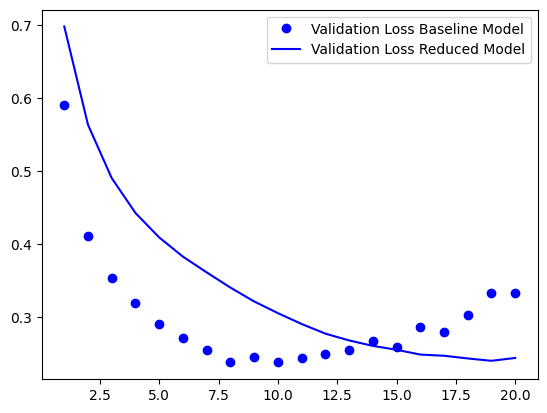

In [ ]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')

#### Adding regularization
To address overfitting, we can also add regularization to the model. Let's try with L2 regularization.

In [ ]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                640064    
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reg_history = deep_model(reg_model)

For the regularized model we notice that it starts overfitting earlier than the baseline model. However, the loss increases much slower afterwards.

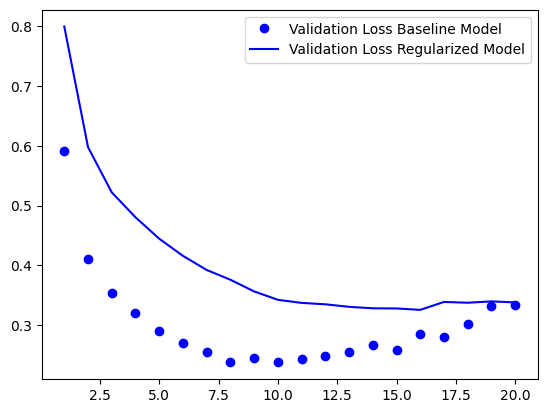

In [ ]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

#### Adding dropout layers
The last option we'll try is to add dropout layers.

In [ ]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [ ]:
drop_history = deep_model(drop_model)

The model with dropout layers starts overfitting a bit later than the baseline model. The loss also increases slower than the baseline model.

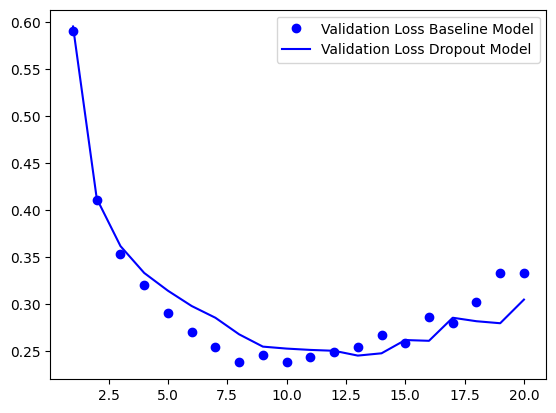

In [ ]:
compare_loss_with_baseline(drop_history, 'Dropout Model')

### Training on the full train data and evaluation on test data
At first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.

In [ ]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [ ]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

13/13 [==============================] - 0s 4ms/step - loss: 0.2418 - accuracy: 0.9550
/n
Test accuracy of baseline model: 95.50%


In [ ]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

13/13 [==============================] - 0s 2ms/step - loss: 0.1831 - accuracy: 0.9575
/n
Test accuracy of reduced model: 95.75%


In [ ]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

13/13 [==============================] - 0s 3ms/step - loss: 0.2615 - accuracy: 0.9575
/n
Test accuracy of regularized model: 95.75%


In [ ]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

13/13 [==============================] - 0s 4ms/step - loss: 0.2681 - accuracy: 0.9600
/n
Test accuracy of dropout model: 96.00%


# Long Short Term Memory (LSTM)

Epoch 1/20
7/7 [==============================] - 5s 308ms/step - loss: 0.5942 - accuracy: 0.0395 - val_loss: 0.3749 - val_accuracy: 0.0361
Epoch 2/20
7/7 [==============================] - 2s 222ms/step - loss: 0.0711 - accuracy: 0.0407 - val_loss: -1.1698 - val_accuracy: 0.0361
Epoch 3/20
7/7 [==============================] - 2s 225ms/step - loss: -2.6675 - accuracy: 0.0407 - val_loss: -4.2879 - val_accuracy: 0.0361
Epoch 4/20
7/7 [==============================] - 2s 225ms/step - loss: -4.7115 - accuracy: 0.0407 - val_loss: -5.6232 - val_accuracy: 0.0361
Epoch 5/20
7/7 [==============================] - 2s 219ms/step - loss: -6.0128 - accuracy: 0.0407 - val_loss: -6.9518 - val_accuracy: 0.0361
Epoch 6/20
7/7 [==============================] - 2s 234ms/step - loss: -7.2812 - accuracy: 0.0407 - val_loss: -8.1791 - val_accuracy: 0.0361
Epoch 7/20
7/7 [==============================] - 2s 226ms/step - loss: -8.4225 - accuracy: 0.0407 - val_loss: -9.2234 - val_accuracy: 0.0361
Epoch 8/2

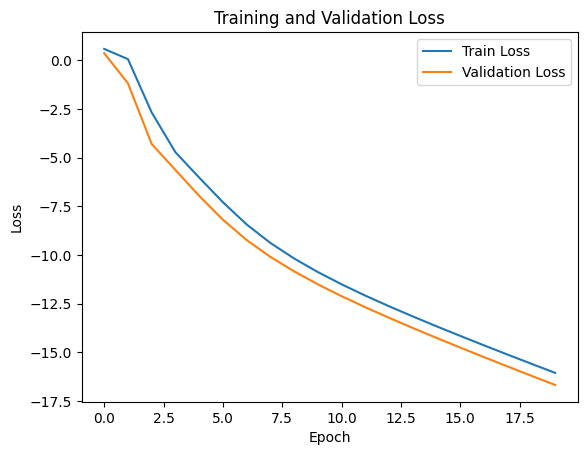

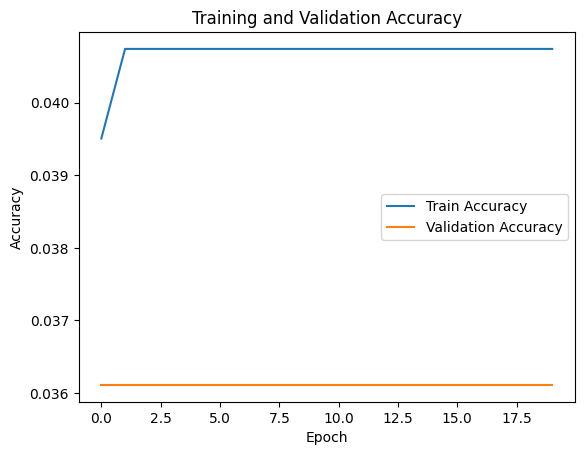

In [86]:


le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df['reviews'], df['sentiment'], test_size=0.1, random_state=37)

# Tokenizar y secuenciar las reseñas
NB_WORDS = 10000  # Número máximo de palabras en el vocabulario
max_len = 100  # Longitud máxima de las secuencias

tokenizer = Tokenizer(num_words=NB_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad para que todas las secuencias tengan la misma longitud
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

# Construir el modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=NB_WORDS, output_dim=32, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
NB_START_EPOCHS = 20  # Número de épocas con las que generalmente empezamos a entrenar
BATCH_SIZE = 512  # Tamaño de los lotes utilizados en el descenso de gradiente de mini-lote

history = model.fit(X_train_padded, y_train, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'\nTest Accuracy: {accuracy:.2f}')

# Mostrar las funciones de pérdida y métricas de rendimiento durante el entrenamiento
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Mostrar la función de pérdida
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Mostrar la métrica de rendimiento (exactitud en este caso)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(history)


# Bidirectional Encoder Representations from Transformers   BERT()

# Conclusion
As we can see above, the model with the dropout layers performs the best on the test data. However, this is slightly lower than what we achieved with a LogisticRegression and Countvectorizer in my previous kernel. But there the input data was transformed a bit different than here. 

### What's next?
Soon I will add the use of word embeddings in Keras and using a pretrained model. To be continued...